In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
!ls ./datasets/AIROGS_partial/RG|wc
# !ls ./

    164     164    2624


In [5]:
# !du -sh ./datasets/AIROGS_partial/
# !ls ./datasets/
# !cp -r ./datasets/AIROGS_partial/ ./datasets/AIROGS_partial/

In [6]:
!ls ./datasets/DDR/images|wc
# !pip uninstall numpy
# !pip install numpy

  13673   13673  259556


In [28]:
# Importing necessary libraries
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import PIL
from PIL import ImageFilter
# from tensorflow.python import keras
from tensorflow import keras
from tensorflow.keras.models import load_model, save_model, Model
# import tensorflow_hub as hub
# from tensorflow.keras.applications import EfficientNetB4, MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import *
import matplotlib.pyplot as plt
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
import os

In [8]:
# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')
# mixed_precision.set_global_policy('float32')
import warnings
warnings.filterwarnings('ignore')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


2023-07-11 11:22:54.593023: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-11 11:22:54.594002: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-11 11:22:54.616697: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-11 11:22:54.616725: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


In [9]:
# df=pd.read_csv("./datasets/Kaggle/retinopathy_solution.csv")
# df2=pd.read_csv("./datasets/Kaggle/trainLabels.csv")
# df=pd.concat([df, df2])
# df=df[['image','level']]
# df= df.drop_duplicates()
# df.to_csv('./datasets/Kaggle/all_labels.csv',header=True, index=False)

dataset_path = r'./datasets/'

idrid_path = dataset_path + "IDRiD/"
kaggle_path = dataset_path + "Kaggle/"
messidor_path = dataset_path + "Messidor-2/"

idrid_path_train_test = dataset_path + "IDRiD/images/train/"
kaggle_path_train_test = dataset_path + "Kaggle/images/"
messidor_path_train_test = dataset_path + "Messidor-2/images/"

kaggle_csv = "./datasets/Kaggle/all_labels.csv"
# kaggle_csv = "./datasets/Kaggle/trainLabels.csv"
idrid_csv = idrid_path + "a. IDRiD_Disease Grading_Training Labels.csv"
messidor_csv = messidor_path + "reference.csv"

idrid_columns = ['Image name', 'Retinopathy grade']
kaggle_columns = ['image', 'level']
messidor_columns = ['i_image','i_adjudicated_dr_grade']

In [10]:
# folder = r'/mnt/data/datasets/Messidor-2/images/'
# files = os.listdir(folder)
# files = os.listdir(idrid_path)

In [11]:
# Define the paths to the image directory and the CSV file
train_image_dir: str = idrid_path_train_test
# train_image_dir: str = kaggle_path_train_test
# train_image_dir: str = messidor_path_train_test
# csv_file_train = idrid_path + 'a. IDRiD_Disease Grading_Training Labels.csv'
# csv_file_test = idrid_path + 'b. IDRiD_Disease Grading_Testing Labels.csv'
csv_file = idrid_csv #kaggle_csv #messidor_csv
# Loading the dataset
df = pd.read_csv(csv_file)

# #uncomment for idrid data
df = df[idrid_columns]
print(df.shape)
df['Image name'] = df['Image name'].astype(str) + ".png"
df['Retinopathy grade'] = df['Retinopathy grade'].astype(str)
df.rename(columns={'Image name': 'img_name', 'Retinopathy grade': 'label'}, inplace=True)
df.dropna(how='all', inplace = True)
df = df[df['label'].notnull()]
df_shuffled = df.sample(frac=1, random_state=1)
# df2 = df_shuffled.copy()
df2 = df_shuffled.iloc[:100]
print(df2.shape)

# # #uncomment for kaggle data
# df = df[kaggle_columns]
# df['image'] = df['image'].astype(str) + ".png"
# df['level'] = df['level'].astype(str)
# df.rename(columns={'image': 'img_name', 'level': 'label'}, inplace=True)
# df.dropna(how='all', inplace = True)
# df = df[df['label'].notnull()]
# df_shuffled = df.sample(frac=1, random_state=1)
# df2=df_shuffled.iloc[:2048]
# df1=df_shuffled.iloc[2048:50048] #including 6000*4 number of elements i.e. max 6000 batches of 4 of which 4500 for training and 1500 for validation
# print(df1.head(),df1.shape, df2.head(),df2.shape)


##uncomment for messidor data
# df = df[messidor_columns]
# df['image'] = df['image'].astype(str) + ".png"
# df['level'] = df['level'].astype(str)
# df.rename(columns={'i_image': 'img_name', 'i_adjudicated_dr_grade': 'label'}, inplace=True)
# df.dropna(how='all', inplace = True)
# df = df[df['label'].notnull()]
# df_shuffled = df.sample(frac=1, random_state=1)
# df2 = df_shuffled.copy()
# print(df2.shape)

# Creating the image generator
# datagen = ImageDataGenerator(rescale=1. / 255)
#rotation_range --> minus to plus number of degrees of rotation
'''
ONE POSSIBLE PREPROCESSING FUNC preprocessing_function=lambda x: np.array(PIL.Image.fromarray(x).filter(ImageFilter.GaussianBlur(radius=2)).getdata()).reshape(data.size[::-1]+(-1,)).astype(np.uint8) if (np.random.rand() < 0.33) else np.array(PIL.Image.fromarray(x).filter(ImageFilter.SHARPEN).getdata()).reshape(data.size[::-1]+(-1,)).astype(np.uint8) if (np.random.rand() < 0.67) else x,
'''
test_datagen = ImageDataGenerator(rescale=None)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df2,
    directory=train_image_dir,
    x_col="img_name",
    y_col="label",
    target_size=(512, 512),
    batch_size=12,
    shuffle=False,
    class_mode='categorical'
    )

(413, 2)
(100, 2)
Found 100 validated image filenames belonging to 5 classes.


In [12]:
# # x = test_generator.next()
# # print(x[0][1].shape)
# plt.imshow(x[0][3]/255)
# # plt.show()
# np.argmax(x[1],axis=1)

# # x[1][5]
# # test_generator.next()[0][0]

In [13]:
# # Evaluate the model on the test set
# # Load the model from .h5 file
# # model = load_model('./RetCAD_models/B4_1024_lr4_float32.h5',compile=False)
# models = ['MobNetv3small_1.0_rev','MobNetv3small_1.0_rev_minimalistic','MobNetv3small_0.75_rev','EffNet_B4_imagenet_norescale_sameastfmodel_rev','EffNet_B5_imagenet_norescale_sameastfmodel_rev','EffNet_B6_imagenet_norescale_sameastfmodel_rev','EffNet_B7_imagenet_norescale_sameastfmodel_rev']
# # print(len(models))
# # for model in models[12:]:
# #     modelloaded = load_model('./'+model+'.h5',compile=False)
# #     print(modelloaded.summary())
# # for model in models:
# #     m = load_model('./'+model+'.h5')
# # #     test_loss, test_acc = m.evaluate(test_generator)
# #     y_true = tf.keras.utils.to_categorical(test_generator.classes)
# #     y_pred = m.predict_generator(test_generator)
# #     print('Test loss for model'+model+': ', test_loss)
# #     print('Test accuracy for model'+model+': ', test_acc)
# #     plot_model(model,y_true,y_pred)



# # m = load_model('./'+models[0]+'.h5')
# # y_true = tf.keras.utils.to_categorical(test_generator.classes)
# # y_pred = m.predict_generator(test_generator)

In [14]:
# len(models)
# # m = load_model('./'+models[2]+'.h5')
# # m.summary()

In [15]:

# modelloaded = tf.keras.applications.efficientnet_v2.EfficientNetV2B3()
# print(modelloaded.summary())
# student_model = MobileNetV3Small(input_shape=(512, 512, 3),include_top=False,weights='imagenet',pooling='avg',alpha=1.0)
# student_model.summary()
# fpr, tpr, _ = roc_curve(np.argmax(y_true_effnet, 1) > 1, y_pred_effnet[:, 2:].sum(1))
# plt.figure()
# plt.plot(fpr, tpr)
# plt.show()

In [16]:
def aggregate_labels(y_true,y_pred):
    original_labels = [0, 1, 2, 3, 4] # original labels
    new_labels = [0, 1] # new labels
    label_map = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1} # mapping from original labels to new labels
    new_y_true = np.zeros((y_true.shape[0], len(new_labels)))
    new_y_pred = np.zeros((y_pred.shape[0], len(new_labels)))
    for i, row in enumerate(y_true):
        for j, val in enumerate(row):
            if val == 1:
                new_label = label_map[original_labels[j]]
                new_y_true[i, new_label] = 1           
    for i, row in enumerate(y_pred):
        for j, val in enumerate(row):
            new_label = label_map[original_labels[j]]
            new_y_pred[i, new_label] += val
#     print("original predictions:\n", y_pred)        
#     print("Aggregated predictions:\n", new_y_pred)
    return new_y_true, new_y_pred

In [17]:
# new_yps[:,1]

In [18]:
# new_yt, new_yp = aggregate_labels(y_true_model,y_pred_model)
# # y_pred_model[1], tf.nn.softmax(y_pred_model[1])
# # y_true_model[:4], y_pred_model[:4]
# new_yts, new_yps =  aggregate_labels(y_true_model,tf.nn.softmax(y_pred_model))

In [19]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, cohen_kappa_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_model_binary(model_name,y_true_original,y_pred_original):
    
    y_true,y_pred=aggregate_labels(y_true_original,y_pred_original)
#     y_true,y_pred=aggregate_labels(y_true_original,y_pred_original)
#     print(np.shape(y_true),np.shape(y_pred))
    
    #saving data to verify manually
    l1 = list(y_true[:,0].T)
    l2 = list(y_true[:,1].T)
    l3 = list(y_pred[:,0].T)
    l4 = list(y_pred[:,1].T)
    l5 = list(np.where(y_pred[:,1].T>0.5,1,0))
    dictionary = {'True 0':l1,'True 1':l2,'Predicted 0':l3,'Predicted 1':l4,'Predicted_Onehot':l5}
#     pd.DataFrame(dictionary).to_csv('results.csv', index = False, header = True)
    
    acc_score = accuracy_score(y_true[:,1],np.where(y_pred[:,1]<=0.5,0,1))
    print('Accuracy:',acc_score)
    
#     kappa_score = cohen_kappa_score(np.argmax(y_true_original,axis=1 ), np.argmax(y_pred_original,axis=1), weights='quadratic')
    kappa_score = cohen_kappa_score(np.argmax(y_true_original,axis=1 ), np.argmax(y_pred_original,axis=1), weights='quadratic')

    print('Quadratic Weighted Kappa:', kappa_score)
    
    # Compute ROC curve and AUC for each class
    # calculate the false positive rate, true positive rate and thresholds using roc_curve
    fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
    # calculate the AUC score using roc_auc_score
    auc_score = roc_auc_score(y_true[:, 1], y_pred[:, 1])
    print("AUROC score for model "+str(model_name)+":", auc_score)

    # plot the ROC curve
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    plt.xlabel('FPR ( or 1 minus Specificity)')
    plt.ylabel('TPR (or Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def plot_model_binary_noact(model_name,y_true_original,y_pred_original):
    
    y_true,y_pred=aggregate_labels(y_true_original,tf.nn.softmax(y_pred_original))
#     y_true,y_pred=aggregate_labels(y_true_original,y_pred_original)
#     print(np.shape(y_true),np.shape(y_pred))
    
    #saving data to verify manually
    l1 = list(y_true[:,0].T)
    l2 = list(y_true[:,1].T)
    l3 = list(y_pred[:,0].T)
    l4 = list(y_pred[:,1].T)
    l5 = list(np.where(y_pred[:,1].T>0.5,1,0))
    dictionary = {'True 0':l1,'True 1':l2,'Predicted 0':l3,'Predicted 1':l4,'Predicted_Onehot':l5}
#     pd.DataFrame(dictionary).to_csv('results.csv', index = False, header = True)
    
    acc_score = accuracy_score(y_true[:,1],np.where(y_pred[:,1]<=0.5,0,1))
    print('Accuracy:',acc_score)
    
#     kappa_score = cohen_kappa_score(np.argmax(y_true_original,axis=1 ), np.argmax(y_pred_original,axis=1), weights='quadratic')
    kappa_score = cohen_kappa_score(np.argmax(y_true_original,axis=1 ), np.argmax(tf.nn.softmax(y_pred_original),axis=1), weights='quadratic')

    print('Quadratic Weighted Kappa:', kappa_score)
    
    # Compute ROC curve and AUC for each class
    # calculate the false positive rate, true positive rate and thresholds using roc_curve
    fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
    # calculate the AUC score using roc_auc_score
    auc_score = roc_auc_score(y_true[:, 1], y_pred[:, 1])
    print("AUROC score for model "+str(model_name)+":", auc_score)

    # plot the ROC curve
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    plt.xlabel('FPR ( or 1 minus Specificity)')
    plt.ylabel('TPR (or Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
def plot_conf_matrix(model_name, y_true_original,y_pred_original):
    
    y_true,y_pred=aggregate_labels(y_true_original,y_pred_original)
    cm = confusion_matrix(y_true[:,1], np.where(y_pred[:,1]<=0.5,0,1))
    # Plot the confusion matrix
    plt.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(i, j, str(cm[i, j]), horizontalalignment='center', verticalalignment='center')
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('Confusion Matrix for model:'+model_name)
    plt.show()

def plot_conf_matrix_noact(model_name, y_true_original,y_pred_original):
    
    y_true,y_pred=aggregate_labels(y_true_original,tf.nn.softmax(y_pred_original))
    cm = confusion_matrix(y_true[:,1], np.where(y_pred[:,1]<=0.5,0,1))
    # Plot the confusion matrix
    plt.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(i, j, str(cm[i, j]), horizontalalignment='center', verticalalignment='center')
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('Confusion Matrix for model:'+model_name)
    plt.show()

def plot_twomodel_roccurve(model1_name,model2_name,y_true_original,y_pred_original1,y_pred_original2):
    
    y_true,y_pred1=aggregate_labels(y_true_original,tf.nn.softmax(y_pred_original1))
    y_true,y_pred2=aggregate_labels(y_true_original,tf.nn.softmax(y_pred_original2))
    # Compute ROC curve and AUC for each class
    # calculate the false positive rate, true positive rate and thresholds using roc_curve
    fpr1, tpr1, _ = roc_curve(y_true[:, 1], y_pred1[:, 1])
    fpr2, tpr2, _ = roc_curve(y_true[:, 1], y_pred2[:, 1])
    # calculate the AUC score using roc_auc_score
    auc_score1 = roc_auc_score(y_true[:, 1], y_pred1[:, 1])
    auc_score2 = roc_auc_score(y_true[:, 1], y_pred2[:, 1])
#     print("AUROC score for model "+str(model1_name)+":", auc_score1)
#     print("AUROC score for model "+str(model2_name)+":", auc_score2)

    # plot the ROC curve
    plt.plot(fpr1, tpr1, color='blue', linestyle='-', linewidth = 0.75, label='{} (AUC = {:.3f})'.format(model1_name,auc_score1))
    plt.plot(fpr2, tpr2, color='red', linestyle='-', linewidth = 0.75, label='{} (AUC = {:.3f})'.format(model2_name,auc_score2))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    plt.xlabel('False Positive Rate ( or 1 minus Specificity)')
    plt.ylabel('True Positive Rate (or Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend(fontsize = 6)
    plt.grid(True, which='both')
    plt.minorticks_on()
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='lower right', fontsize=8) # bbox_to_anchor=(1, 0.5)
#     plt.rcParams.update({'font.size': 12}) # setting the font size of the plot's title, x-axis label, y-axis label, and legend labels
    plt.show()    
    

def plot_multimodel_roccurve(model1_name,model2_name,model3_name,y_true_original,y_pred_original1,y_pred_original2,y_pred_original3):
    
    y_true,y_pred1=aggregate_labels(y_true_original,tf.nn.softmax(y_pred_original1))
    y_true,y_pred2=aggregate_labels(y_true_original,tf.nn.softmax(y_pred_original2))
    y_true,y_pred3=aggregate_labels(y_true_original,tf.nn.softmax(y_pred_original3))
    # Compute ROC curve and AUC for each class
    # calculate the false positive rate, true positive rate and thresholds using roc_curve
    fpr1, tpr1, _ = roc_curve(y_true[:, 1], y_pred1[:, 1])
    fpr2, tpr2, _ = roc_curve(y_true[:, 1], y_pred2[:, 1])
    fpr3, tpr3, _ = roc_curve(y_true[:, 1], y_pred3[:, 1])
    # calculate the AUC score using roc_auc_score
    auc_score1 = roc_auc_score(y_true[:, 1], y_pred1[:, 1])
    auc_score2 = roc_auc_score(y_true[:, 1], y_pred2[:, 1])
    auc_score3 = roc_auc_score(y_true[:, 1], y_pred3[:, 1])
#     print("AUROC score for model "+str(model1_name)+":", auc_score1)
#     print("AUROC score for model "+str(model2_name)+":", auc_score2)

    # plot the ROC curve
    plt.plot(fpr1, tpr1, color='blue', linestyle='-', linewidth = 0.75, label='{} (AUC = {:.3f})'.format(model1_name,auc_score1))
    plt.plot(fpr2, tpr2, color='red', linestyle='-', linewidth = 0.75, label='{} (AUC = {:.3f})'.format(model2_name,auc_score2))
    plt.plot(fpr3, tpr3, color='green', linestyle='-', linewidth = 0.9, label='{} (AUC = {:.3f})'.format(model3_name,auc_score3))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    plt.xlabel('False Positive Rate ( or 1 minus Specificity)')
    plt.ylabel('True Positive Rate (or Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend(fontsize = 6)
    plt.grid(True, which='both')
    plt.minorticks_on()
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='lower right', fontsize=8) # bbox_to_anchor=(1, 0.5)
#     plt.rcParams.update({'font.size': 12}) # setting the font size of the plot's title, x-axis label, y-axis label, and legend labels
    plt.show()

In [20]:
# modelmobile = MobileNetV3Small(input_shape=(512, 512, 3),include_top=False,weights='imagenet',pooling='avg',alpha=1.0,minimalistic=True)
# modelmobile.summary()

In [21]:
# plot_model_binary(models[0],y_true,y_pred)
# plot_conf_matrix(models[0],y_true,y_pred)
# models

### Code for Distilled Models

In [22]:
# y_pred_model.shape

In [23]:
# # loaded_model = tf.keras.models.load_model('./EffNetB0_distilled_final4')
# # loaded_model = tf.keras.models.load_model('./EffNetB1_distilled_bestmodel_7')
# # loaded_model = tf.keras.models.load_model('./MobNetv3small_1.0_distilled_final2')
# # loaded_model = tf.keras.models.load_model('./MobNetv3small_1.0_distilled_final5')
# loaded_model = tf.keras.models.load_model('./MobNetv3small_1.0_minimalistic_distilled_finalmodel_exp15')
# # loaded_model = tf.saved_model.load('./student_model_bestmodel_temp')
# # loaded_model = tf.keras.models.load_model('./student_model_bestmodel_temp')
# # predictions = loaded_model.predict(test_generator)
# # model = DistillationModel.from_saved_model('./EffNetB1_distilled_bestmodel_7')
# y_pred_model = loaded_model.predict(test_generator)
# y_true_model = tf.keras.utils.to_categorical(test_generator.classes)
# # y_pred_model = m.predict(test_generator)
# plot_model_binary('Teacher_ensemble_b4b5b6_retcad',y_true_model,y_pred_model)
# plot_conf_matrix('Teacher_ensemble_b4b5b6_retcad',y_true_model,y_pred_model)

In [24]:
# save_model(loaded_model, 'exp15.h5')


### Removing activation layer from Saved trained Models and plot performance

In [25]:
# # model_path = './models/teacher_experiments/ResNet152.h5'
# # model_path = './models/teacher_experiments/ResNet50.h5'
# model_path = './models/student_experiments/NASNetMobile.h5'

# mod = load_model(model_path)
# # nod = mod.pop()
# # mod.layers.pop()
# new_mod = Model(inputs = mod.inputs, outputs = mod.layers[-2].output, name = mod.name)
# # new_mod.save('./models/teacher_experiments/ResNet50_NoActivation.h5')
# new_mod.save('./models/student_experiments/NASNetMobile_NoActivation.h5')
# # print(nod.name)
# # new_mod.summary()
# # new_mod.name

In [26]:
# model_path = './models/teacher_experiments/ResNet50_NoActivation.h5'
# # model_path = './models/student_experiments/NASNetMobile_NoActivation.h5'
# mod = load_model(model_path)
# y_true_model = tf.keras.utils.to_categorical(test_generator.classes)
# y_pred_model = mod.predict(test_generator)
# plot_conf_matrix(mod.name,y_true_model,y_pred_model)
# plot_model_binary(mod.name,y_true_model,y_pred_model)

### Code for single model plots

#### Teacher models with inference time

In [27]:
import time
models = ['14_EffNet_B4_imagenet_norescale_sameastfmodel_rev.h5','15_EffNet_B5_imagenet_norescale_sameastfmodel_rev.h5',
          '16_EffNet_B6_imagenet_norescale_sameastfmodel_rev.h5','17_EffNet_B7_imagenet_norescale_sameastfmodel_rev.h5']#
ensembles = ['teacher_ensemble_v3_b4b5b6.h5']
y_true_model = tf.keras.utils.to_categorical(test_generator.classes)
for model in models:
    m = load_model('./models/teacher_experiments/'+model)
    start_time = time.time()
    y_pred_model = m.predict(test_generator)
    end_time = time.time()
    inference_time = end_time - start_time
#     plot_conf_matrix(m.name,y_true_model,y_pred_model)
#     plot_model_binary(m.name,y_true_model,y_pred_model)
    print("Model:", model)
    print("Inference Time:", inference_time, "seconds")
    print("---")
for model in ensembles[-1:]:
    m = load_model('./models/teacher_ensembles/'+model)
    start_time = time.time()
    y_pred_model = m.predict(test_generator)
    end_time = time.time()
    inference_time = end_time - start_time
#     plot_conf_matrix(m.name,y_true_model,y_pred_model)
#     plot_model_binary(m.name,y_true_model,y_pred_model)
    print("Model:", model)
    print("Inference Time:", inference_time, "seconds")
    print("---")

2023-07-10 21:58:17.898177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 21:58:17.901682: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-10 21:58:26.168345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-10 21:58:26.190500: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


Model: 14_EffNet_B4_imagenet_norescale_sameastfmodel_rev.h5
Inference Time: 409.17581033706665 seconds
---
Model: 15_EffNet_B5_imagenet_norescale_sameastfmodel_rev.h5
Inference Time: 614.4838700294495 seconds
---
Model: 16_EffNet_B6_imagenet_norescale_sameastfmodel_rev.h5
Inference Time: 834.3630704879761 seconds
---
Model: 17_EffNet_B7_imagenet_norescale_sameastfmodel_rev.h5
Inference Time: 1283.6688396930695 seconds
---
Model: teacher_ensemble_v3_b4b5b6.h5
Inference Time: 1678.5088603496552 seconds
---


#### Distilled students with inference time

In [28]:
# models = ['MobNetv3small_1.0_minimalistic_distilled_finalexp1_epoch13.h5','MobNetv3small_1.0_minimalistic_distilled_finalexp2_epoch416.h5','EffNetB0_distilled_finalexp3_epoch359.h5','EffNetB0_distilled_finalexp4_epoch109.h5','EffNetB1_distilled_finalexp5_epoch79.h5',
#           'EffNetB1_distilled_finalexp6_epoch271.h5','EffNetB0_distilled_finalexp7_epoch86.h5','EffNetB1_distilled_finalexp8_epoch176.h5','EffNetB2_distilled_finalexp9_epoch155.h5','EffNetB2_distilled_finalexp10_epoch48.h5','EffNetB2_distilled_finalexp11_epoch128.h5','EffNetB2_distilled_finalexp12_epoch80.h5',
#           'EffNetB2_distilled_finalexp13_epoch186.h5','EffNetB2_distilled_finalexp14_epoch151.h5','EffNetB2_distilled_finalexp15_epoch81.h5','EffNetB0_distilled_finalexp16_epoch86.h5','EffNetB1_distilled_finalexp17_epoch238.h5','EffNetB0_distilled_withTclassifier_finalexp18_epoch192.h5',
#           'EffNetB1_distilled_withTclassifier_finalexp19_epoch124.h5','EffNetB2_distilled_withTclassifier_finalexp20_epoch144.h5','EffNetB0_distilled_finalexp21_epoch212.h5','EffNetB0_distilled_finalexp22_epoch420.h5','EffNetB0_distilled_finalexp23_epoch250.h5','EffNetB0_distilled_finalexp24_epoch209.h5','EffNetB1_distilled_finalexp25_epoch328.h5',
#           'EffNetB2_distilled_finalexp26_epoch511.h5']#
# y_true_model = tf.keras.utils.to_categorical(test_generator.classes)
# for model in models[-1:]:
#     m = load_model('./models/distilled_students/'+model)
# #     m = load_model('./'+'teacher_ensemble_b4b5b6_retcad'+'.h5')
# #     m = load_model('./models/teacher_ensembles/'+'teacher_ensemble_v3_b4b5b6'+'.h5')
# #     m = load_model('./models/teacher_experiments/EffNet_B5_exp15.h5')
#     y_pred_model = m.predict(test_generator)
#     plot_conf_matrix_noact(m.name,y_true_model,y_pred_model)
#     plot_model_binary_noact(m.name,y_true_model,y_pred_model)

In [29]:
# m.summary()

2023-07-11 11:23:51.332098: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-11 11:23:51.350500: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


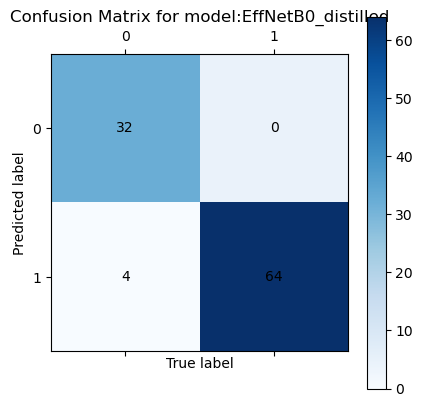

Accuracy: 0.96
Quadratic Weighted Kappa: 0.9250037498125093
AUROC score for model EffNetB0_distilled: 0.9969618055555555


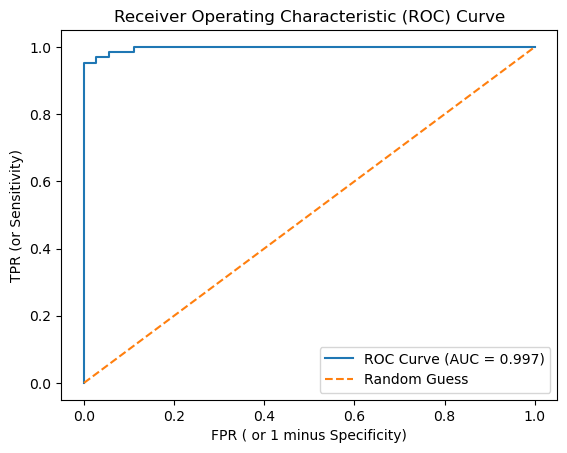

Model: EffNetB0_distilled_finalexp21.h5
Inference Time: 9.284289360046387 seconds
---


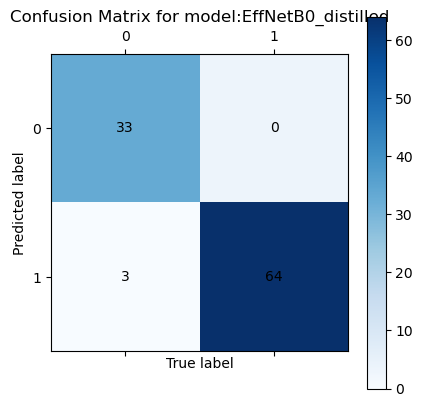

Accuracy: 0.97
Quadratic Weighted Kappa: 0.9319893126062667
AUROC score for model EffNetB0_distilled: 0.9995659722222222


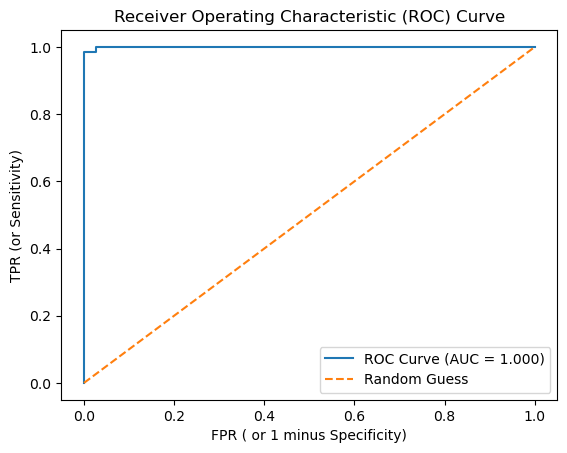

Model: EffNetB0_distilled_finalexp22.h5
Inference Time: 8.971846342086792 seconds
---


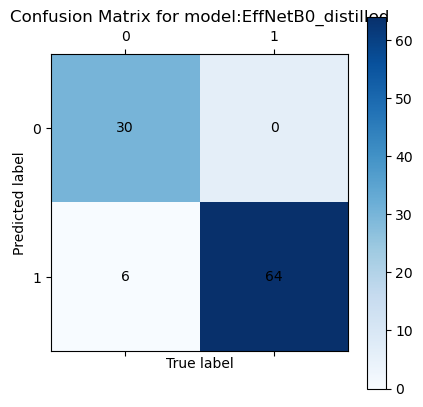

Accuracy: 0.94
Quadratic Weighted Kappa: 0.9138236934151164
AUROC score for model EffNetB0_distilled: 0.997829861111111


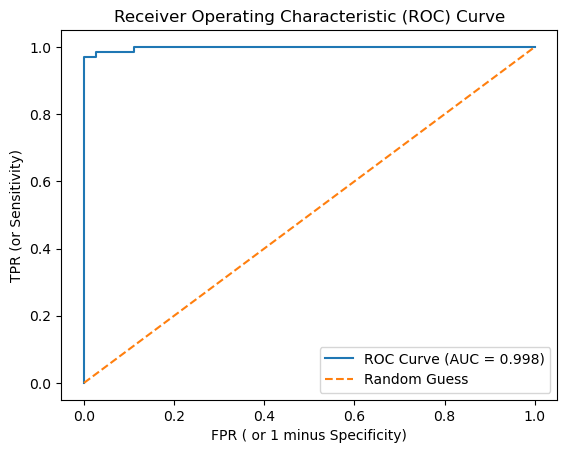

Model: EffNetB0_distilled_finalexp23.h5
Inference Time: 9.128399848937988 seconds
---


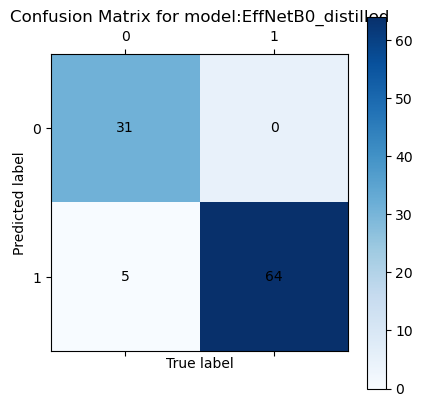

Accuracy: 0.95
Quadratic Weighted Kappa: 0.9005519367510317
AUROC score for model EffNetB0_distilled: 0.9969618055555556


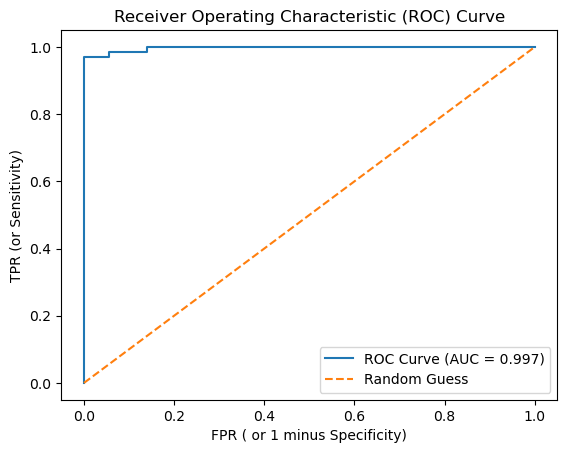

Model: EffNetB0_distilled_finalexp24.h5
Inference Time: 9.02458667755127 seconds
---


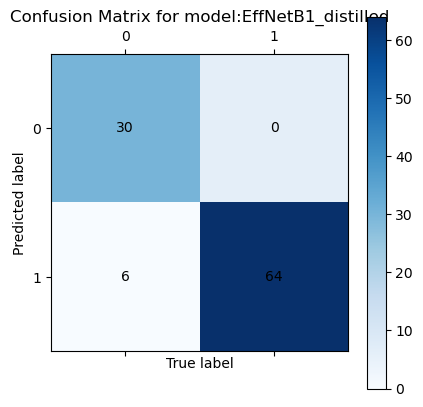

Accuracy: 0.94
Quadratic Weighted Kappa: 0.8870708693033527
AUROC score for model EffNetB1_distilled: 0.9973958333333334


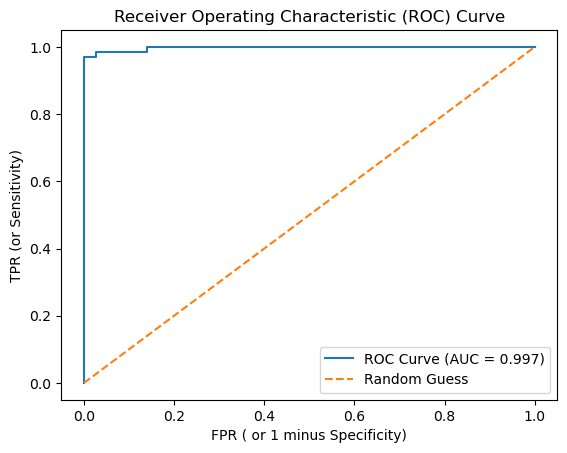

Model: EffNetB1_distilled_finalexp25.h5
Inference Time: 12.282052516937256 seconds
---


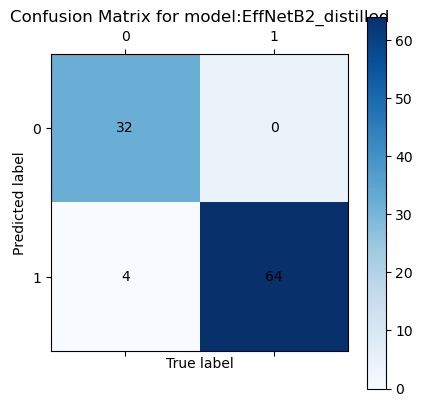

Accuracy: 0.96
Quadratic Weighted Kappa: 0.8920345489443378
AUROC score for model EffNetB2_distilled: 0.997829861111111


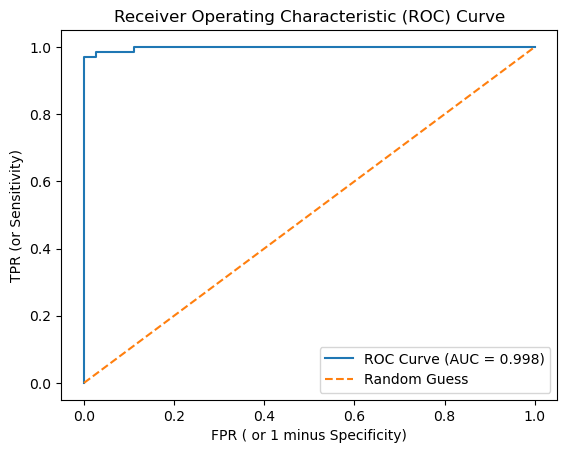

Model: EffNetB2_distilled_finalexp26.h5
Inference Time: 13.22055697441101 seconds
---


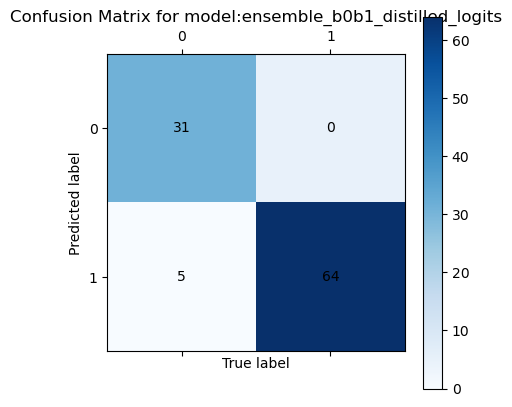

Accuracy: 0.95
Quadratic Weighted Kappa: 0.9100494727899655
AUROC score for model ensemble_b0b1_distilled_logits: 0.9973958333333333


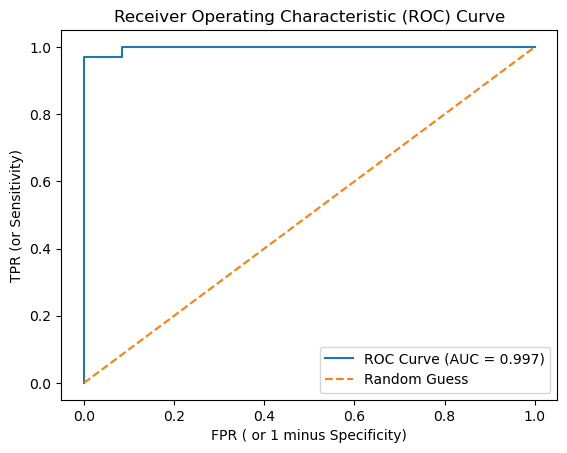

Model: student_distilled_ensemble_b0b1_NoActivation.h5
Inference Time: 18.856462001800537 seconds
---


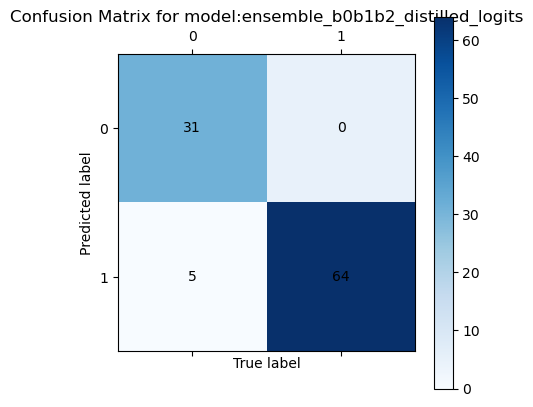

Accuracy: 0.95
Quadratic Weighted Kappa: 0.8950577182549597
AUROC score for model ensemble_b0b1b2_distilled_logits: 0.997829861111111


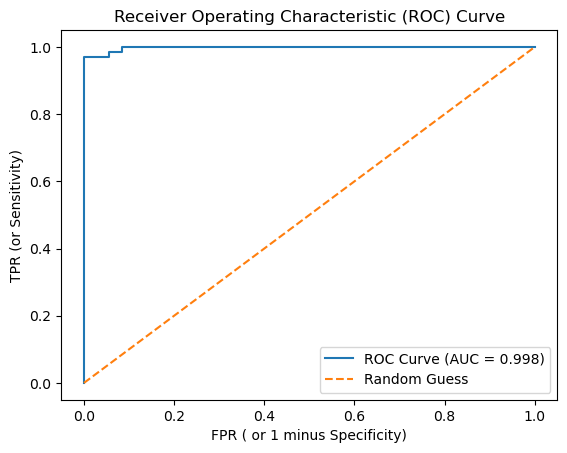

Model: student_distilled_ensemble_b0b1b2_NoActivation.h5
Inference Time: 28.50754952430725 seconds
---


In [29]:
models = ['MobNetv3small_1.0_minimalistic_distilled_finalexp1.h5','MobNetv3small_1.0_minimalistic_distilled_finalexp2.h5','EffNetB0_distilled_finalexp3.h5',
          'EffNetB0_distilled_finalexp4.h5','EffNetB1_distilled_finalexp5_epoch79.h5','EffNetB1_distilled_finalexp6.h5',
          'EffNetB0_distilled_finalexp7.h5','EffNetB1_distilled_finalexp8.h5','EffNetB2_distilled_finalexp9.h5',
          'EffNetB2_distilled_finalexp10.h5','EffNetB2_distilled_finalexp11.h5','EffNetB2_distilled_finalexp12.h5',
          'EffNetB2_distilled_finalexp13.h5','EffNetB2_distilled_finalexp14.h5','EffNetB2_distilled_finalexp15.h5',
          'EffNetB0_distilled_finalexp16.h5','EffNetB1_distilled_finalexp17.h5','EffNetB0_distilled_withTclassifier_finalexp18.h5',
          'EffNetB1_distilled_withTclassifier_finalexp19.h5','EffNetB2_distilled_withTclassifier_finalexp20.h5',
          'EffNetB0_distilled_finalexp21.h5','EffNetB0_distilled_finalexp22.h5','EffNetB0_distilled_finalexp23.h5',
          'EffNetB0_distilled_finalexp24.h5','EffNetB1_distilled_finalexp25.h5','EffNetB2_distilled_finalexp26.h5',
          'student_distilled_ensemble_b0b1_NoActivation.h5','student_distilled_ensemble_b0b1b2_NoActivation.h5']#
y_true_model = tf.keras.utils.to_categorical(test_generator.classes)
for model in models[-8:]:
    m = load_model('./models/distilled_students/'+model)
    start_time = time.time()
    y_pred_model = m.predict(test_generator)
    end_time = time.time()
    inference_time = end_time - start_time
    plot_conf_matrix_noact(m.name,y_true_model,y_pred_model)
    plot_model_binary_noact(m.name,y_true_model,y_pred_model)
    print("Model:", model)
    print("Inference Time:", inference_time, "seconds")
    print("---")

### Memory and Compute / FLOPS summary

In [37]:
# Effnet_b5_exp15_logits
m = load_model('./models/teacher_experiments/EffNet_B7_exp17_NoActivation.h5')
new_model = Model(inputs = m.inputs, outputs = m.output, name = 'Effnet_b7_exp17_logits')
# new_model.save('')
# new_model.summary()
new_model.save('./models/teacher_experiments/EffNet_B7_exp17_NoActivation.h5')

In [38]:
# from tensorflow.python.profiler import profiler_client
# models_stud = [#"EffNet_B0_imagenet_norescale_sameastfmodel_rev_NoActivation.h5",
#                #"EffNet_B1_imagenet_norescale_sameastfmodel_rev_NoActivation.h5",
#                #"EffNet_B2_imagenet_norescale_sameastfmodel_rev_NoActivation.h5",
#                "E1_student_scratch_ensemble_b0b1_NoActivation.h5",
#                "E2_student_scratch_ensemble_b0b1b2_NoActivation.h5"]
# for i, model in enumerate(models_stud[0:1]):
#     model_path = './models/student_experiments/' + model
#     m = load_model(model_path)
#     # Compile the ensemble model (add your own compilation settings)
#     m.compile(optimizer='adam', loss='categorical_crossentropy')

#     # Generate some example input data
#     batch_size = 4
#     input_data = tf.random.normal((batch_size, 512, 512, 3))

#     # Run a forward pass to initialize the model
#     _ = m.predict(input_data)
#     # Start profiling
#     tf.profiler.experimental.start('logs')
#     # Perform a forward pass with profiling
#     _ = m.predict(input_data)
#     # Stop profiling
#     tf.profiler.experimental.stop()

# #     # Start the profiler
# #     profiler_client.start_profiler('localhost:6006')

# #     # Perform a forward pass with profiling
# #     _ = m.predict(input_data)

# #     # Stop the profiler
# #     profiler_client.stop_profiler('localhost:6006')


In [39]:
# !pip install model-profiler
# !tensorboard --logdir=logs --host=0.0.0.0

In [43]:
import pandas as pd
import re
# CODE TO PROFILE FLOPS for each model

from model_profiler import model_profiler
batch_size_stud=[4,4,4,4,4]
batch_size_teacher=[4,4,4,4]
batch_size_distilled = [4,4,4,4,4]
models_stud = ["EffNet_B0_imagenet_norescale_sameastfmodel_rev_NoActivation.h5",
               "EffNet_B1_imagenet_norescale_sameastfmodel_rev_NoActivation.h5",
               "EffNet_B2_imagenet_norescale_sameastfmodel_rev_NoActivation.h5",
               "E1_student_scratch_ensemble_b0b1_NoActivation.h5",
               "E2_student_scratch_ensemble_b0b1b2_NoActivation.h5"]
models_teacher=["EffNet_B5_exp15_NoActivation.h5", "EffNet_B6_exp16_NoActivation.h5",
                "EffNet_B7_exp17_NoActivation.h5","ensemble_v3_NoActivation.h5"]#
distilled_models = ["EffNetB0_distilled_finalexp21.h5","EffNetB1_distilled_finalexp25.h5",
                    "EffNetB2_distilled_finalexp26.h5","student_distilled_ensemble_b0b1_NoActivation.h5",
                    "student_distilled_ensemble_b0b1b2_NoActivation.h5"]#

# Create empty lists to store the profile information
model_roles = []
model_names = []
selected_gpus = []
flops_values = []
flops_units = []
gpu_memory_values = []
gpu_memory_units = []
model_params_values = []
model_params_units = []
memory_req_values = []
memory_req_units = []
# profile
# l = profile.split('|')
# newl=[(i,l[i]) for i in range(len(l))]
# newl
for i, model in enumerate(models_stud):
    model_path = './models/student_experiments/' + model
    m = load_model(model_path)
#     # Count the number of trainable and non-trainable parameters
#     trainable_params = m.count_params()
#     non_trainable_params = sum([tf.keras.backend.count_params(w) for w in m.non_trainable_weights])

#     # Print the counts
#     print(m.name)
#     print("Trainable Parameters:", trainable_params)
#     print("Non-trainable Parameters:", non_trainable_params)
    profile = model_profiler(m, batch_size_stud[i])
#     print(profile)
    lines = profile.split('\n')
    model_names.append(m.name)
    model_roles.append('Undistilled Student')
#     print('\n')
#     print(lines)
    for line in lines[2:]:
        matches = re.findall(r'\|(.+?)\|(.+?)\|(.+?)\|', line)
        if matches:
            key = matches[0][0].strip()
            value = matches[0][1].strip()
            unit = matches[0][2].strip()            
            if key == 'Selected GPUs':
                selected_gpus.append(value)
            elif key == 'No. of FLOPs':
                flops_values.append(float(value))
                flops_units.append(unit)
            elif key == 'GPU Memory Requirement':
                gpu_memory_values.append(float(value))
                gpu_memory_units.append(unit)
            elif key == 'Model Parameters':
                model_params_values.append(float(value))
                model_params_units.append(unit)
            elif key == 'Memory Required by Model Weights':
                memory_req_values.append(float(value))
                memory_req_units.append(unit)

for i,model in enumerate(models_teacher):
    model_path = './models/teacher_experiments/' + model
    m = load_model(model_path)    
    profile = model_profiler(m, batch_size_teacher[i])
    lines = profile.split('\n')
    model_names.append(m.name)
    model_roles.append('Teacher')
    for line in lines[2:]:
        matches = re.findall(r'\|(.+?)\|(.+?)\|(.+?)\|', line)
        if matches:
            key = matches[0][0].strip()
            value = matches[0][1].strip()
            unit = matches[0][2].strip()            
            if key == 'Selected GPUs':
                selected_gpus.append(value)
            elif key == 'No. of FLOPs':
                flops_values.append(float(value))
                flops_units.append(unit)
            elif key == 'GPU Memory Requirement':
                gpu_memory_values.append(float(value))
                gpu_memory_units.append(unit)
            elif key == 'Model Parameters':
                model_params_values.append(float(value))
                model_params_units.append(unit)
            elif key == 'Memory Required by Model Weights':
                memory_req_values.append(float(value))
                memory_req_units.append(unit)

for i,model in enumerate(distilled_models):
    model_path = './models/distilled_students/' + model
    m = load_model(model_path)    
    profile = model_profiler(m, batch_size_distilled[i])    
    lines = profile.split('\n')
    model_names.append(m.name)
    model_roles.append('Distilled Student')
    for line in lines[2:]:
        matches = re.findall(r'\|(.+?)\|(.+?)\|(.+?)\|', line)
        if matches:
            key = matches[0][0].strip()
            value = matches[0][1].strip()
            unit = matches[0][2].strip()            
            if key == 'Selected GPUs':
                selected_gpus.append(value)
            elif key == 'No. of FLOPs':
                flops_values.append(float(value))
                flops_units.append(unit)
            elif key == 'GPU Memory Requirement':
                gpu_memory_values.append(float(value))
                gpu_memory_units.append(unit)
            elif key == 'Model Parameters':
                model_params_values.append(float(value))
                model_params_units.append(unit)
            elif key == 'Memory Required by Model Weights':
                memory_req_values.append(float(value))
                memory_req_units.append(unit)

# Create a DataFrame using the collected data
data = {
    "Model Role": model_roles,
    "Model Name": model_names,
    "Selected GPUs": selected_gpus,
    "FLOPs Values": flops_values,
    "FLOPs Units": flops_units,
    "GPU Memory Values": gpu_memory_values,
    "GPU Memory Units": gpu_memory_units,
    "Model Parameters Values": model_params_values,
    "Model Parameters Units": model_params_units,
    "Memory Required Values": memory_req_values,
    "Memory Required Units": memory_req_units
}
# data
df = pd.DataFrame(data)
df.head(15)
df.to_csv('MemoryStats.csv', header=True, index=False)

EffNet_B0_exp21_NoActivation
Trainable Parameters: 4055976
Non-trainable Parameters: 42023.0


2023-07-11 10:57:22.418880: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-11 10:57:22.419654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-11 10:57:22.419696: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-11 10:57:22.419721: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-07-11 10:57:22.419733: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-07-11 10:57:22.419744: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuff

EffNet_B1_exp22_NoActivation
Trainable Parameters: 6581644
Non-trainable Parameters: 62055.0


2023-07-11 10:57:24.608517: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-11 10:57:24.609241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-11 10:57:24.609290: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-11 10:57:24.609314: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-07-11 10:57:24.609323: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-07-11 10:57:24.609332: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuff

EffNet_B2_exp23_NoActivation
Trainable Parameters: 7775614
Non-trainable Parameters: 67575.0


2023-07-11 10:57:26.915879: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-11 10:57:26.916614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-11 10:57:26.916652: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-11 10:57:26.916673: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-07-11 10:57:26.916682: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-07-11 10:57:26.916691: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuff

ensemble_b0b1_scratch_logits
Trainable Parameters: 10637620
Non-trainable Parameters: 104078.0


2023-07-11 10:57:31.808265: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-11 10:57:31.808938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-11 10:57:31.808976: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-11 10:57:31.809000: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-07-11 10:57:31.809012: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-07-11 10:57:31.809022: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuff

ensemble_b0b1b2_scratch_logits
Trainable Parameters: 18413234
Non-trainable Parameters: 171653.0


2023-07-11 10:57:40.493064: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-11 10:57:40.493758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-11 10:57:40.493811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-11 10:57:40.493833: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-07-11 10:57:40.493842: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-07-11 10:57:40.493851: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuff

In [42]:
# !tensorboard --logdir=logs --host=0.0.0.0
# df.head(20)

### ROUGHWORK - NEXT FEW COMMANDS

In [29]:
# mod.summary()

In [30]:
# # mod = load_model('./models/teacher_experiments/EffNet_B4_exp14_NoActivation.h5')
# mod = load_model('./teacher_ensemble_NoActivation.h5')
# # mod.summary()
# y_true_mod = tf.keras.utils.to_categorical(test_generator.classes)
# y_pred_mod = mod.predict(test_generator)

In [31]:
# y_pred_mod

In [32]:
# inputs = mod.inputs
# outputs = mod.layers[-2].output
# model_without_softmax = tf.keras.Model(inputs=inputs, outputs=outputs)
# logits = model_without_softmax.predict(test_generator)
# # logits.shape
# logits.max()

In [33]:
# model_without_softmax.save('./models/teacher_experiments/EffNet_B6_exp16_NoActivation.h5')

In [34]:
# y_pred_model

In [35]:
# # tf.nn.softmax(y_pred_mod)
# plot_model_binary('Teacher_noact',y_true_model,tf.nn.softmax(y_pred_mod))
# plot_conf_matrix('Teacher_noact',y_true_model,tf.nn.softmax(y_pred_mod))

### Code for multi-model plots

#### Plot Type 1

In [36]:
# scratchstudents_ensemble = load_model('./models/student_experiments/'+'student_scratch_ensemble_b0b1b2_NoActivation'+'.h5')
# distilledstudents_ensemble = load_model('./models/distilled_students/'+'student_distilled_ensemble_b0b1b2_NoActivation'+'.h5')
# y_true = tf.keras.utils.to_categorical(test_generator.classes)
# y_pred_studscratch_ensemble = scratchstudents_ensemble.predict_generator(test_generator)
# y_pred_studdistilled_ensemble = distilledstudents_ensemble.predict_generator(test_generator)
# plot_twomodel_roccurve('student_scratch_ensemble_b0b1b2','student_distilled_ensemble_b0b1b2',y_true,y_pred_studscratch_ensemble,y_pred_studdistilled_ensemble)

#### Plot Type 2

2023-06-27 10:46:25.051662: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 10:46:25.096983: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-27 10:46:25.117827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-06-27 10:46:25.117908: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-27 10:46:25.117943: I tensorflow/stream_executor/

2023-06-27 10:46:54.465413: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-27 10:46:54.489918: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2023-06-27 10:47:06.674830: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-27 10:47:06.997593: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-27 10:47:08.558109: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-06-27 10:47:08.696769: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


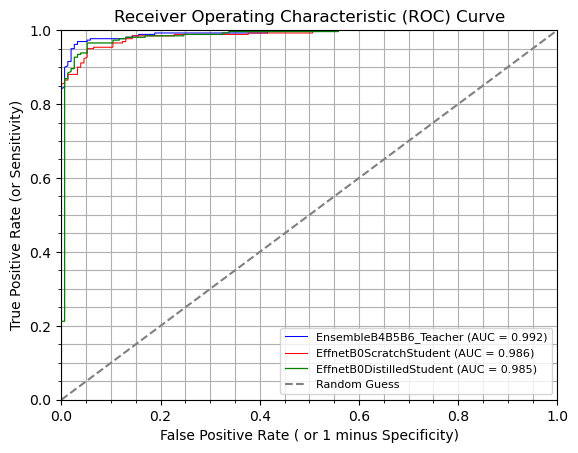

In [37]:
# # teacher = load_model('./models/teacher_experiments/'+'EffNet_B7_exp17_NoActivation.h5')
# teacher = load_model('./models/teacher_ensembles/'+'ensemble_v3_NoActivation.h5')
# studentscratch = load_model('./models/student_experiments/'+'EffNet_B0_imagenet_norescale_sameastfmodel_rev_NoActivation'+'.h5')
# studentdistilled = load_model('./models/distilled_students/'+'EffNetB0_distilled_finalexp23'+'.h5')
# y_true = tf.keras.utils.to_categorical(test_generator.classes)
# y_pred_teacher = teacher.predict_generator(test_generator)
# y_pred_studscratch = studentscratch.predict_generator(test_generator)
# y_pred_studdist = studentdistilled.predict_generator(test_generator)
# plot_multimodel_roccurve('EnsembleB4B5B6_Teacher','EffnetB0ScratchStudent','EffnetB0DistilledStudent',y_true,y_pred_teacher,y_pred_studscratch,y_pred_studdist)

### Calculating Ensemble Performance Here

### A. Performance of Saved ensemble v2 b4b5b6b7

In [37]:
# # Load the ensemble model for prediction later
# loaded_ensemble_model = load_model('teacher_ensemble.h5')
# # loaded_ensemble_model = ensemble_model
# # Use the loaded ensemble model to make predictions
# y_true_ensemble = tf.keras.utils.to_categorical(test_generator.classes)
# y_pred_ensemble = loaded_ensemble_model.predict_generator(test_generator)
# plot_model_binary('Teacher_ensemble',y_true_ensemble,y_pred_ensemble)
# plot_conf_matrix('Teacher_ensemble',y_true_ensemble,y_pred_ensemble)

### B. Performance of Saved ensemble v3 b4b5b6

In [38]:
# # Load the ensemble model for prediction later
# loaded_ensemble_model = load_model('teacher_ensemble_b4b5b6.h5')
# # Use the loaded ensemble model to make predictions
# y_true_ensemble = tf.keras.utils.to_categorical(test_generator.classes)
# y_pred_ensemble = loaded_ensemble_model.predict_generator(test_generator)
# plot_model_binary('Teacher_ensemble',y_true_ensemble,y_pred_ensemble)
# plot_conf_matrix('Teacher_ensemble',y_true_ensemble,y_pred_ensemble)

### C. Performance of ensemble on the go from the individual models loaded below

In [39]:
# mods=['EffNet_B5_imagenet_norescale_sameastfmodel','EffNet_B6_imagenet_norescale_sameastfmodel',
#  'EffNet_B7_imagenet_norescale_sameastfmodel','EffNet_B4_imagenet_norescale_sameastfmodel']
# model1 = load_model('./'+mods[0]+'.h5')
# model2 = load_model('./'+mods[1]+'.h5')
# model3 = load_model('./'+mods[2]+'.h5')
# model4 = load_model('./'+mods[3]+'.h5')
# y_true_ensemble = tf.keras.utils.to_categorical(test_generator.classes)
# all_models=[model1,model2,model3,model4]
# y_pred_ensemble=[]
# for model in all_models:
#         y_pred_ensemble.append(model.predict_generator(test_generator))

### D. Performance of saved ensemble student scratch and distilled student models

2023-06-27 04:57:56.878103: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 04:57:56.881998: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-27 04:57:56.882740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-06-27 04:57:56.882779: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-27 04:57:56.882800: I tensorflow/stream_executor/

2023-06-27 04:58:07.048488: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-27 04:58:07.069860: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2023-06-27 04:58:12.891820: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-27 04:58:13.249791: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-27 04:58:14.769903: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-06-27 04:58:14.915703: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


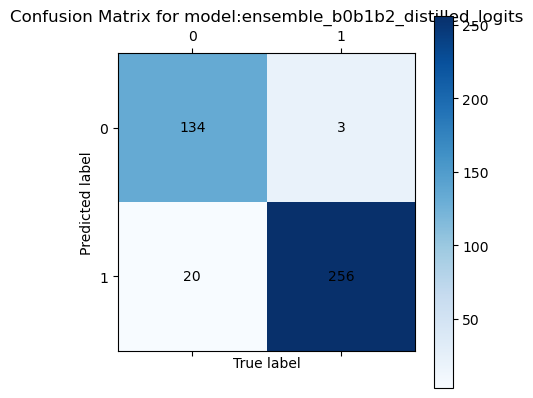

Accuracy: 0.9443099273607748
Quadratic Weighted Kappa: 0.8662711923017676
AUROC score for model ensemble_b0b1b2_distilled_logits: 0.9917389560246703


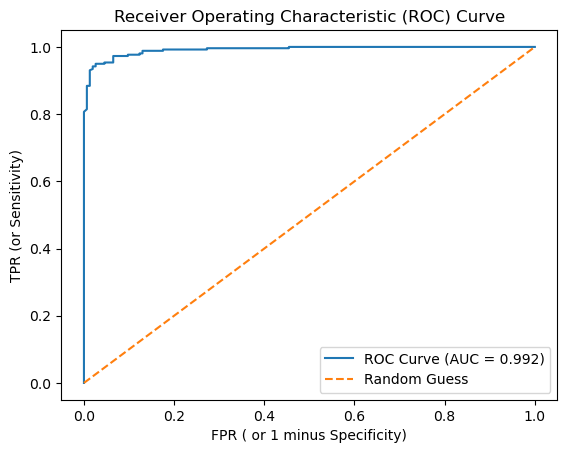

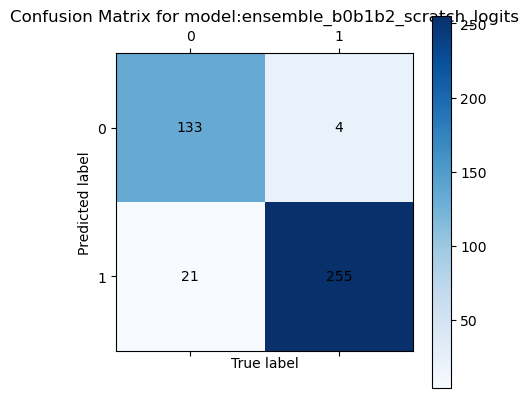

Accuracy: 0.9394673123486683
Quadratic Weighted Kappa: 0.8646525542518949
AUROC score for model ensemble_b0b1b2_scratch_logits: 0.991250062678634


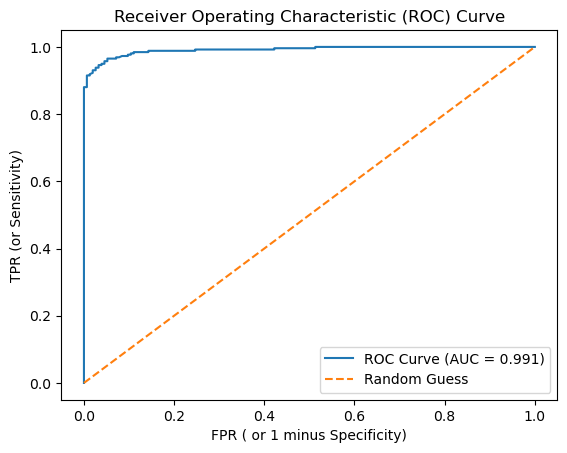

In [40]:
# models = ['./models/distilled_students/student_distilled_ensemble_b0b1b2_NoActivation.h5',
#           './models/student_experiments/student_scratch_ensemble_b0b1b2_NoActivation.h5']#
# y_true_model = tf.keras.utils.to_categorical(test_generator.classes)
# for model in models:
#     m = load_model(model)
# #     m = load_model('./EffNet_B2_imagenet_norescale_sameastfmodel_rev.h5')
# #     m = load_model('./'+'teacher_ensemble_b4b5b6_retcad'+'.h5')
# #     m = load_model('./models/teacher_ensembles/'+'teacher_ensemble_v3_b4b5b6'+'.h5')
# #     m = load_model('./models/teacher_experiments/EffNet_B5_exp15.h5')
#     y_pred_model = m.predict(test_generator)
#     plot_conf_matrix(m.name,y_true_model,y_pred_model)
#     plot_model_binary(m.name,y_true_model,y_pred_model)

In [ ]:
# y_pred_ensemble = np.mean(y_pred_ensemble, axis=0)
# y_true_ensemble = tf.keras.utils.to_categorical(test_generator.classes)
# plot_model_binary('Teacher_ensemble',y_true_ensemble,y_pred_ensemble)
# plot_conf_matrix('Teacher_ensemble',y_true_ensemble,y_pred_ensemble)

In [ ]:
# x = train_generator.next()

In [ ]:
# x[0].shape

In [ ]:
# m.predict(x[0]).argmax(1)

In [ ]:
# plt.imshow(x[0][10])